#**Diabetes Rate Based on Income & Access to Food Suppliers**

*compiled by:* Bryan Flanagan & Ben Russell

*github site:* https://bennyboy54.github.io

###**Initial Data Sourcing:**

For this tutorial, we will use an official USDA dataset that collects many food related statistics across every state and county in the U.S. This dataset tracks access to food in different areas, different household variables, restaurants and stores, expenditures for food establishments, and income of households by counties in the United States. It was produced in 2020 and largely focuses on data from 2011-2018.

*Dataset can be found here:* https://www.ers.usda.gov/data-products/food-environment-atlas/

###**Question**

The main question we want to answer utilizing this data is how do certain aspects of living, like household income, access to food supplies, and access to exercise facilities affect the diabetes rate in a county.

The dataset provides the diabetes rate of every county, as well as variables showing the number of groccery stores, convienence stores, and fast food establishments per 1000 people. We also can pull a varibale for the number of gyms per 1000 people.

###**Hypothesis**

Before creating any correlations or data models, we want to make a general hypothesis of what this data will show us. We believe that there will be a negative relationship between diabetes rate and household income. This negative correlation will also exsist for access to gyms. Diabetes may also have a positive correlation on access to fast food and convience stores.

###**Process**

In order to explore and attempt to prove our hypothesis, we will conduct many correlation calculations along with multiple visual representations of this data through graphs, heatmaps, and histograms. To check the validity of these relationships, we will also conduct a linear regression model and a K-nearest-neighbors regression. We will create a 'fantasy' county will altered attributes so we can test the effects of each parameter on diabetes rate.


###Extracting Data

In the below cell, we import our data. We are looking at FDA records from every county in the United States cataloging various criteria, mostly revolving around food access and population demographics.

Since there are multiple sheets in the Excel document, we will merge them all into one large dataframe. This makes the data far more accessbile for analysis and testing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import pearsonr

In [ ]:
pd.set_option('display.max_columns', None)
food_atlas = pd.ExcelFile('/content/drive/MyDrive/Notability/Data Science/food_atlas_mile_2.xlsx')
#food_atlas = pd.ExcelFile('FoodEnvironmentAtlas Mergable.xlsx')
list_dataframes = []

for sheet in food_atlas.sheet_names:
  list_dataframes.append(food_atlas.parse(sheet))
df = pd.concat(list_dataframes, axis=1)
initial_df = df.loc[:,~df.columns.duplicated()].copy()
initial_df = initial_df.drop([3143])
initial_df.astype({'FIPS':'string'})

,FIPS,County,State,2010_Census_Population,Population_Estimate_2011,Population_Estimate_2012,Population_Estimate_2013,Population_Estimate_2014,Population_Estimate_2015,Population_Estimate_2016,Population_Estimate_2017,Population_Estimate_2018,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,LACCESS_HHNV10,LACCESS_HHNV15,PCH_LACCESS_HHNV_10_15,PCT_LACCESS_HHNV10,PCT_LACCESS_HHNV15,LACCESS_SNAP15,PCT_LACCESS_SNAP15,LACCESS_CHILD10,LACCESS_CHILD15,LACCESS_CHILD_10_15,PCT_LACCESS_CHILD10,PCT_LACCESS_CHILD15,LACCESS_SENIORS10,LACCESS_SENIORS15,PCH_LACCESS_SENIORS_10_15,PCT_LACCESS_SENIORS10,PCT_LACCESS_SENIORS15,LACCESS_WHITE15,PCT_LACCESS_WHITE15,LACCESS_BLACK15,PCT_LACCESS_BLACK15,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,GROC11,GROC16,PCH_GROC_11_16,GROCPTH11,GROCPTH16,PCH_GROCPTH_11_16,SUPERC11,SUPERC16,PCH_SUPERC_11_16,SUPERCPTH11,SUPERCPTH16,PCH_SUPERCPTH_11_16,CONVS11,CONVS16,PCH_CONVS_11_16,CONVSPTH11,CONVSPTH16,PCH_CONVSPTH_11_16,SPECS11,SPECS16,PCH_SPECS_11_16,SPECSPTH11,SPECSPTH16,PCH_SPECSPTH_11_16,SNAPS12,SNAPS17,PCH_SNAPS_12_17,SNAPSPTH12,SNAPSPTH17,PCH_SNAPSPTH_12_17,WICS11,WICS16,PCH_WICS_11_16,WICSPTH11,WICSPTH16,PCH_WICSPTH_11_16,FFR11,FFR16,PCH_FFR_11_16,FFRPTH11,FFRPTH16,PCH_FFRPTH_11_16,FSR11,FSR16,PCH_FSR_11_16,FSRPTH11,FSRPTH16,PCH_FSRPTH_11_16,PC_FFRSALES07,PC_FFRSALES12,PC_FSRSALES07,PC_FSRSALES12,REDEMP_SNAPS12,REDEMP_SNAPS17,PCH_REDEMP_SNAPS_12_17,PCT_SNAP12,PCT_SNAP17,PCH_SNAP_12_17,PC_SNAPBEN12,PC_SNAPBEN17,PCH_PC_SNAPBEN_12_17,SNAP_PART_RATE11,SNAP_PART_RATE16,SNAP_OAPP09,SNAP_OAPP16,SNAP_CAP09,SNAP_CAP16,SNAP_BBCE09,SNAP_BBCE16,SNAP_REPORTSIMPLE09,SNAP_REPORTSIMPLE16,PCT_NSLP12,PCT_NSLP17,PCH_NSLP_12_17,PCT_FREE_LUNCH10,PCT_FREE_LUNCH15,PCT_REDUCED_LUNCH10,PCT_REDUCED_LUNCH15,PCT_SBP12,PCT_SBP17,PCH_SBP_12_17,PCT_SFSP12,PCT_SFSP17,PCH_SFSP_12_17,PC_WIC_REDEMP11,PC_WIC_REDEMP16,PCH_PC_WIC_REDEMP_11_16,REDEMP_WICS11,REDEMP_WICS16,PCH_REDEMP_WICS_11_16,PCT_WIC12,PCT_WIC17,PCH_WIC_12_17,PCT_WICINFANTCHILD14,PCT_WICINFANTCHILD16,PCH_WICINFANTCHILD_14_16,PCT_WICWOMEN14,PCT_WICWOMEN16,PCH_WICWOMEN_14_16,PCT_CACFP12,PCT_CACFP17,PCH_CACFP_12_17,FDPIR12,FDPIR15,PCH_FDPIR_12_15,FOOD_BANKS18,FOODINSEC_12_14,FOODINSEC_15_17,CH_FOODINSEC_14_17,VLFOODSEC_12_14,VLFOODSEC_15_17,CH_VLFOODSEC_14_17,SODATAX_STORES14,SODATAX_VENDM14,CHIPSTAX_STORES14,CHIPSTAX_VENDM14,FOOD_TAX14,DIRSALES_FARMS07,DIRSALES_FARMS12,PCH_DIRSALES_FARMS_07_12,PCT_LOCLFARM07,PCT_LOCLFARM12,PCT_LOCLSALE07,PCT_LOCLSALE12,DIRSALES07,DIRSALES12,PCH_DIRSALES_07_12,PC_DIRSALES07,PC_DIRSALES12,PCH_PC_DIRSALES_07_12,FMRKT13,FMRKT18,PCH_FMRKT_13_18,FMRKTPTH13,FMRKTPTH18,PCH_FMRKTPTH_13_18,FMRKT_SNAP18,PCT_FMRKT_SNAP18,FMRKT_WIC18,PCT_FMRKT_WIC18,FMRKT_WICCASH18,PCT_FMRKT_WICCASH18,FMRKT_SFMNP18,PCT_FMRKT_SFMNP18,FMRKT_CREDIT18,PCT_FMRKT_CREDIT18,FMRKT_FRVEG18,PCT_FMRKT_FRVEG18,FMRKT_ANMLPROD18,PCT_FMRKT_ANMLPROD18,FMRKT_BAKED18,PCT_FMRKT_BAKED18,FMRKT_OTHERFOOD18,PCT_FMRKT_OTHERFOOD18,VEG_FARMS07,VEG_FARMS12,PCH_VEG_FARMS_07_12,VEG_ACRES07,VEG_ACRES12,PCH_VEG_ACRES_07_12,VEG_ACRESPTH07,VEG_ACRESPTH12,PCH_VEG_ACRESPTH_07_12,FRESHVEG_FARMS07,FRESHVEG_FARMS12,PCH_FRESHVEG_FARMS_07_12,FRESHVEG_ACRES07,FRESHVEG_ACRES12,PCH_FRESHVEG_ACRES_07_12,FRESHVEG_ACRESPTH07,FRESHVEG_ACRESPTH12,PCH_FRESHVEG_ACRESPTH_07_12,ORCHARD_FARMS07,ORCHARD_FARMS12,PCH_ORCHARD_FARMS_07_12,ORCHARD_ACRES07,ORCHARD_ACRES12,PCH_ORCHARD_ACRES_07_12,ORCHARD_ACRESPTH07,ORCHARD_ACRESPTH12,PCH_ORCHARD_ACRESPTH_07_12,BERRY_FARMS07,BERRY_FARMS12,PCH_BERRY_FARMS_07_12,BERRY_ACRES07,BERRY_ACRES12,PCH_BERRY_ACRES_07_12,BERRY_ACRESPTH07,BERRY_ACRESPTH12,PCH_BERRY_ACRESPTH_07_12,SLHOUSE07,SLHOUSE12,PCH_SLHOUSE_07_12,GHVEG_FARMS07,GHVEG_FARMS12,PCH_GHVEG_FARMS_07_12,GHVEG_SQFT07,GHVEG_SQFT12,PCH_GHVEG_SQFT_07_12,GHVEG_SQFTPTH07,GHVEG_SQFTPT

Above, we can see the full table and all of its different columns. There are a great deal of different points of study observed by the dataset. Below are some simple summary statistics for the numerical datatypes within the set.

In [ ]:
numerical_data = initial_df.drop(['FIPS','County', 'State', 'PERPOV10', 'CHILDPOVRATE15', 'PERCHLDPOV10', 'METRO13', 'POPLOSS10', 'SNAP_OAPP09', 'SNAP_OAPP16', 'SNAP_CAP09',
                                'SNAP_CAP16', 'SNAP_BBCE09','SNAP_BBCE09','SNAP_REPORTSIMPLE09','SNAP_REPORTSIMPLE16','FARM_TO_SCHOOL13','FARM_TO_SCHOOL15'], axis=1)
numerical_data.describe().apply(lambda s: s.apply('{0:.5f}'.format))


,2010_Census_Population,Population_Estimate_2011,Population_Estimate_2012,Population_Estimate_2013,Population_Estimate_2014,Population_Estimate_2015,Population_Estimate_2016,Population_Estimate_2017,Population_Estimate_2018,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,LACCESS_HHNV10,LACCESS_HHNV15,PCH_LACCESS_HHNV_10_15,PCT_LACCESS_HHNV10,PCT_LACCESS_HHNV15,LACCESS_SNAP15,PCT_LACCESS_SNAP15,LACCESS_CHILD10,LACCESS_CHILD15,LACCESS_CHILD_10_15,PCT_LACCESS_CHILD10,PCT_LACCESS_CHILD15,LACCESS_SENIORS10,LACCESS_SENIORS15,PCH_LACCESS_SENIORS_10_15,PCT_LACCESS_SENIORS10,PCT_LACCESS_SENIORS15,LACCESS_WHITE15,PCT_LACCESS_WHITE15,LACCESS_BLACK15,PCT_LACCESS_BLACK15,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,GROC11,GROC16,PCH_GROC_11_16,GROCPTH11,GROCPTH16,PCH_GROCPTH_11_16,SUPERC11,SUPERC16,PCH_SUPERC_11_16,SUPERCPTH11,SUPERCPTH16,PCH_SUPERCPTH_11_16,CONVS11,CONVS16,PCH_CONVS_11_16,CONVSPTH11,CONVSPTH16,PCH_CONVSPTH_11_16,SPECS11,SPECS16,PCH_SPECS_11_16,SPECSPTH11,SPECSPTH16,PCH_SPECSPTH_11_16,SNAPS12,SNAPS17,PCH_SNAPS_12_17,SNAPSPTH12,SNAPSPTH17,PCH_SNAPSPTH_12_17,WICS11,WICS16,PCH_WICS_11_16,WICSPTH11,WICSPTH16,PCH_WICSPTH_11_16,FFR11,FFR16,PCH_FFR_11_16,FFRPTH11,FFRPTH16,PCH_FFRPTH_11_16,FSR11,FSR16,PCH_FSR_11_16,FSRPTH11,FSRPTH16,PCH_FSRPTH_11_16,PC_FFRSALES07,PC_FFRSALES12,PC_FSRSALES07,PC_FSRSALES12,REDEMP_SNAPS12,REDEMP_SNAPS17,PCH_REDEMP_SNAPS_12_17,PCT_SNAP12,PCT_SNAP17,PCH_SNAP_12_17,PC_SNAPBEN12,PC_SNAPBEN17,PCH_PC_SNAPBEN_12_17,SNAP_PART_RATE11,SNAP_PART_RATE16,SNAP_BBCE16,PCT_NSLP12,PCT_NSLP17,PCH_NSLP_12_17,PCT_FREE_LUNCH10,PCT_FREE_LUNCH15,PCT_REDUCED_LUNCH10,PCT_REDUCED_LUNCH15,PCT_SBP12,PCT_SBP17,PCH_SBP_12_17,PCT_SFSP12,PCT_SFSP17,PCH_SFSP_12_17,PC_WIC_REDEMP11,PC_WIC_REDEMP16,PCH_PC_WIC_REDEMP_11_16,REDEMP_WICS11,REDEMP_WICS16,PCH_REDEMP_WICS_11_16,PCT_WIC12,PCT_WIC17,PCH_WIC_12_17,PCT_WICINFANTCHILD14,PCT_WICINFANTCHILD16,PCH_WICINFANTCHILD_14_16,PCT_WICWOMEN14,PCT_WICWOMEN16,PCH_WICWOMEN_14_16,PCT_CACFP12,PCT_CACFP17,PCH_CACFP_12_17,FDPIR12,FDPIR15,PCH_FDPIR_12_15,FOOD_BANKS18,FOODINSEC_12_14,FOODINSEC_15_17,CH_FOODINSEC_14_17,VLFOODSEC_12_14,VLFOODSEC_15_17,CH_VLFOODSEC_14_17,SODATAX_STORES14,SODATAX_VENDM14,CHIPSTAX_STORES14,CHIPSTAX_VENDM14,FOOD_TAX14,DIRSALES_FARMS07,DIRSALES_FARMS12,PCH_DIRSALES_FARMS_07_12,PCT_LOCLFARM07,PCT_LOCLFARM12,PCT_LOCLSALE07,PCT_LOCLSALE12,DIRSALES07,DIRSALES12,PCH_DIRSALES_07_12,PC_DIRSALES07,PC_DIRSALES12,PCH_PC_DIRSALES_07_12,FMRKT13,FMRKT18,PCH_FMRKT_13_18,FMRKTPTH13,FMRKTPTH18,PCH_FMRKTPTH_13_18,FMRKT_SNAP18,PCT_FMRKT_SNAP18,FMRKT_WIC18,PCT_FMRKT_WIC18,FMRKT_WICCASH18,PCT_FMRKT_WICCASH18,FMRKT_SFMNP18,PCT_FMRKT_SFMNP18,FMRKT_CREDIT18,PCT_FMRKT_CREDIT18,FMRKT_FRVEG18,PCT_FMRKT_FRVEG18,FMRKT_ANMLPROD18,PCT_FMRKT_ANMLPROD18,FMRKT_BAKED18,PCT_FMRKT_BAKED18,FMRKT_OTHERFOOD18,PCT_FMRKT_OTHERFOOD18,VEG_FARMS07,VEG_FARMS12,PCH_VEG_FARMS_07_12,VEG_ACRES07,VEG_ACRES12,PCH_VEG_ACRES_07_12,VEG_ACRESPTH07,VEG_ACRESPTH12,PCH_VEG_ACRESPTH_07_12,FRESHVEG_FARMS07,FRESHVEG_FARMS12,PCH_FRESHVEG_FARMS_07_12,FRESHVEG_ACRES07,FRESHVEG_ACRES12,PCH_FRESHVEG_ACRES_07_12,FRESHVEG_ACRESPTH07,FRESHVEG_ACRESPTH12,PCH_FRESHVEG_ACRESPTH_07_12,ORCHARD_FARMS07,ORCHARD_FARMS12,PCH_ORCHARD_FARMS_07_12,ORCHARD_ACRES07,ORCHARD_ACRES12,PCH_ORCHARD_ACRES_07_12,ORCHARD_ACRESPTH07,ORCHARD_ACRESPTH12,PCH_ORCHARD_ACRESPTH_07_12,BERRY_FARMS07,BERRY_FARMS12,PCH_BERRY_FARMS_07_12,BERRY_ACRES07,BERRY_ACRES12,PCH_BERRY_ACRES_07_12,BERRY_ACRESPTH07,BERRY_ACRESPTH12,PCH_BERRY_ACRESPTH_07_12,SLHOUSE07,SLHOUSE12,PCH_SLHOUSE_07_12,GHVEG_FARMS07,GHVEG_FARMS12,PCH_GHVEG_FARMS_07_12,GHVEG_SQFT07,GHVEG_SQFT12,PCH_GHVEG_SQFT_07_12,GHVEG_SQFTPTH07,GHVEG_SQFTPTH12,PCH_GHVEG_SQFTPTH_07_12,FOODHUB18,CSA07,CSA12,PCH_CSA_07_12,AGRITRSM_OPS07,AGRITRSM_OPS12,PCH_AGRITRSM_OPS_07_12

###Preliminary Data Analysis

Below is a heatmap of the variables that we hypothesized may have a relationship with one another. The appropriate correlation will also be supplied for the relevant graph.

<Axes: >

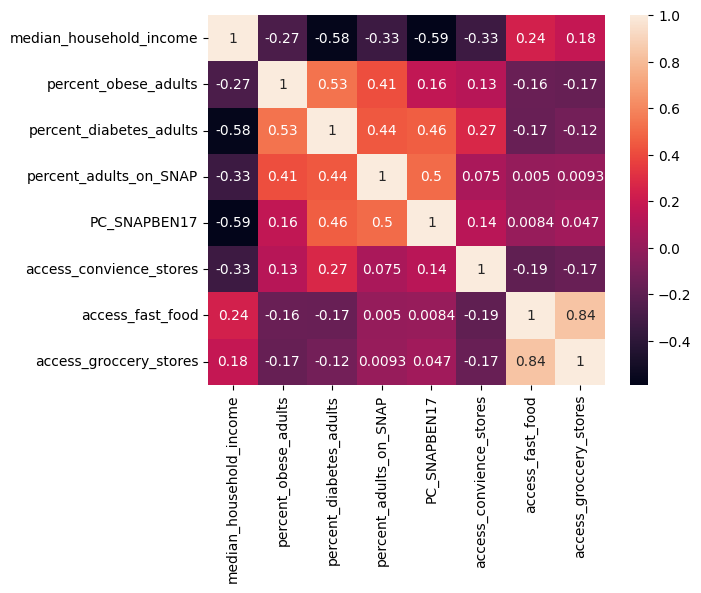

In [ ]:
correlated_vars = initial_df[['MEDHHINC15', 'PCT_OBESE_ADULTS17', 'PCT_DIABETES_ADULTS13', 'PCT_SNAP17','PC_SNAPBEN17','CONVSPTH16', 'FFR16', 'GROC16']]
correlated_vars = correlated_vars.rename(columns={'MEDHHINC15': 'median_household_income', 'PCT_OBESE_ADULTS17': 'percent_obese_adults', 'PCT_DIABETES_ADULTS13': 'percent_diabetes_adults', 'PCT_SNAP17': 'percent_adults_on_SNAP', 'CONVSPTH16': 'access_convience_stores', 'FFR16': 'access_fast_food', 'GROC16': "access_groccery_stores"})
sns.heatmap(correlated_vars.corr(), annot=True)

First, we can look at two plots that compare the median annual household income with the obesity percentage by county and the diabetes percentage by county. Though our main focus is diabetes rate, obesity rate still gives a good understanding of how overall health outcomes are related to all of our studied parameters. The obesity variable is done by state, meaning that there are not specific values for each county, causing the graph to form lines, representing the state as a whole.

The third plot shows the relationship between income and diabetes percentage but uses the obesity percentage as a third factor represented by the plasma "heat" coloration. This can show us that income and diabetes are correlated along with obesity.

R of median household income and state obesity percentage: -0.2746736643258992
R of median household income and county diabetes percentage: -0.5752571563655029


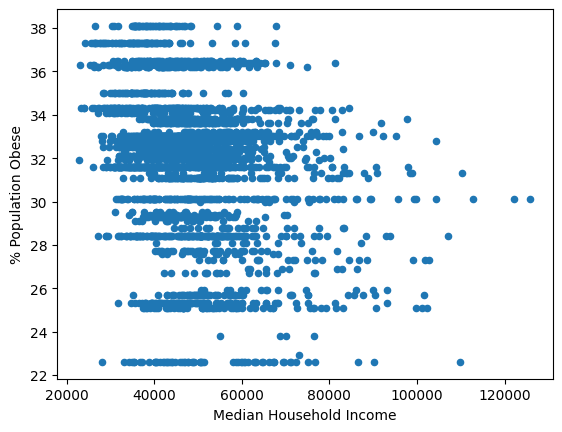

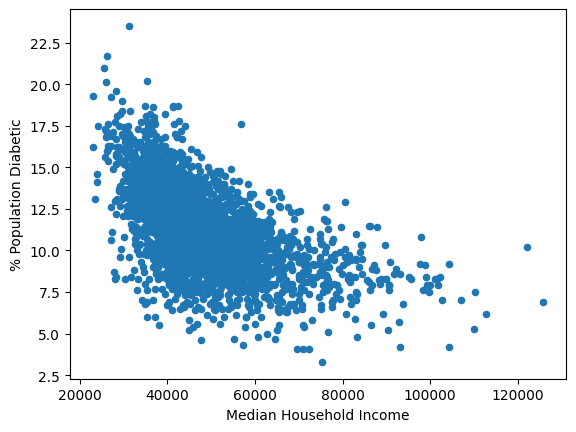

In [ ]:
plot1 = initial_df.plot.scatter(x="MEDHHINC15", y="PCT_OBESE_ADULTS17")
plot1.set_xlabel("Median Household Income")
plot1.set_ylabel("% Population Obese")

plot2 = initial_df.plot.scatter(x="MEDHHINC15", y="PCT_DIABETES_ADULTS13")
plot2.set_xlabel("Median Household Income")
plot2.set_ylabel("% Population Diabetic")

print("R of median household income and state obesity percentage:", initial_df['MEDHHINC15'].corr(initial_df['PCT_OBESE_ADULTS17']))
print("R of median household income and county diabetes percentage:", initial_df['MEDHHINC15'].corr(initial_df['PCT_DIABETES_ADULTS13']))

Text(0, 0.5, '% Population Diabetic')

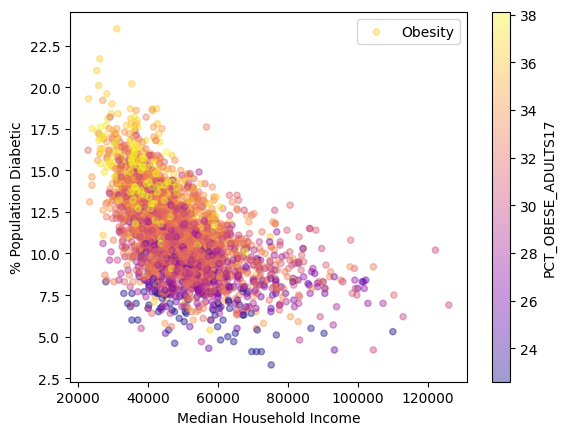

In [ ]:
plot3 = initial_df.plot.scatter(x="MEDHHINC15", y="PCT_DIABETES_ADULTS13",
                     c="PCT_OBESE_ADULTS17", cmap="plasma", alpha=.4, label = "Obesity");
plot3.set_xlabel("Median Household Income")
plot3.set_ylabel("% Population Diabetic")

Another form of correlation we wanted to test was if many of the lower income counties are the same counties that have the highest diabetes rates. In order to show this we made two seperate dataframes, one that compiles the counties in the bottom 25th percentile of income, and another that compiles the counties in the top 25th percentile of diabetes rate.

First we had to create a specificed dataset that only houses the state and county indexes, along with the percentage of adults with diabetes, and the median household income

In [ ]:
 #building a seperate dataframe to compare income and diabetes
inc_obs = initial_df[["State", "County", "PCT_DIABETES_ADULTS13", "MEDHHINC15"]].copy()
inc_obs = inc_obs.rename(columns={'PCT_DIABETES_ADULTS13': 'percent_adults_diabetes', 'MEDHHINC15': 'median_household_income'})
inc_obs_sorted = inc_obs.sort_values(by=['State', 'County'], ascending=[True, True])
inc_obs_sorted

,State,County,percent_adults_diabetes,median_household_income
0,Alabama,Autauga,13.0,56580.0
1,Alabama,Baldwin,10.4,52387.0
2,Alabama,Barbour,18.4,31433.0
3,Alabama,Bibb,14.8,40767.0
4,Alabama,Blount,14.1,50487.0
...,...,...,...,...
3139,Wyoming,Teton,4.8,83290.0
3140,Wyoming,Uinta,9.0,62968.0
3141,Wyoming,Washakie,12.0,56088.0
3119,Wyoming,Wood,8.1,51025.0


In [ ]:
#Looking at the bottom 25% of median income by county
quant = (inc_obs_sorted["median_household_income"].quantile(.25))
print("bottom 25% of income is:", quant)
bot_25_inc = inc_obs_sorted[inc_obs_sorted['median_household_income'] <= quant]
print(bot_25_inc)

bottom 25% of income is: 40438.0
               State     County  percent_adults_diabetes  \
2            Alabama    Barbour                     18.4   
5            Alabama    Bullock                     19.6   
6            Alabama     Butler                     17.7   
8            Alabama   Chambers                     16.4   
9            Alabama   Cherokee                     13.3   
...              ...        ...                      ...   
3042   West Virginia      Wayne                     16.5   
3043   West Virginia    Webster                     16.7   
3049       Wisconsin    Ashland                     11.0   
3087       Wisconsin  Menominee                     13.9   
3047       Wisconsin    Wyoming                     14.9   

      median_household_income  
2                     31433.0  
5                     28251.0  
6                     33868.0  
8                     35560.0  
9                     39144.0  
...                       ...  
3042                  

In [ ]:
#looking at top 25% of diabetes by county
quant = (inc_obs_sorted["percent_adults_diabetes"].quantile(.75))
print("top 25% of diabetes is:", quant)
top_25_dbt = inc_obs_sorted[inc_obs_sorted['percent_adults_diabetes'] >= quant]
print(top_25_dbt)

top 25% of diabetes is: 12.9
               State     County  percent_adults_diabetes  \
0            Alabama    Autauga                     13.0   
2            Alabama    Barbour                     18.4   
3            Alabama       Bibb                     14.8   
4            Alabama     Blount                     14.1   
5            Alabama    Bullock                     19.6   
...              ...        ...                      ...   
3044   West Virginia     Wetzel                     13.0   
3045   West Virginia       Wirt                     14.8   
3046   West Virginia       Wood                     14.0   
3087       Wisconsin  Menominee                     13.9   
3047       Wisconsin    Wyoming                     14.9   

      median_household_income  
0                     56580.0  
2                     31433.0  
3                     40767.0  
4                     50487.0  
5                     28251.0  
...                       ...  
3044                  4183

Here, we perform an inner join on the top 25% highest diabetes rates and bottom 25% of median household incomes. This shows us how many counties occupy both regions, giving us insight into the potential relationship here. We can see that 478 out of the total 790 counties occupy both lists, meaning that over half of the counties that fall in the bottom 25th percentile of income also fall in the top 25th percentile of diabetes rates.

In [ ]:
bot_25_inc
top_bot_merged = pd.merge(bot_25_inc, top_25_dbt, left_index=True, right_index=True, how='inner')
top_bot_merged

,State_x,County_x,percent_adults_diabetes_x,median_household_income_x,State_y,County_y,percent_adults_diabetes_y,median_household_income_y
2,Alabama,Barbour,18.4,31433.0,Alabama,Barbour,18.4,31433.0
5,Alabama,Bullock,19.6,28251.0,Alabama,Bullock,19.6,28251.0
6,Alabama,Butler,17.7,33868.0,Alabama,Butler,17.7,33868.0
8,Alabama,Chambers,16.4,35560.0,Alabama,Chambers,16.4,35560.0
9,Alabama,Cherokee,13.3,39144.0,Alabama,Cherokee,13.3,39144.0
...,...,...,...,...,...,...,...,...
3039,West Virginia,Tucker,13.8,38000.0,West Virginia,Tucker,13.8,38000.0
3042,West Virginia,Wayne,16.5,35537.0,West Virginia,Wayne,16.5,35537.0
3043,West Virginia,Webster,16.7,30673.0,West Virginia,Webster,16.7,30673.0
3087,Wisconsin,Menominee,13.9,33410.0,Wisconsin,Menominee,13.9,33410.0


###Exploring more relationships

After confirming that median household income and diabetes rates are negativly correlated and do have an affect on eachother we want to look at how the other variables may also affect diabetes rate. These external variables include access to groccery, convienence, and fast food stores, along with access to recreational facilities. Below are some histograms and graphs that show possible relationships between diabetes rate and the variables listed above.

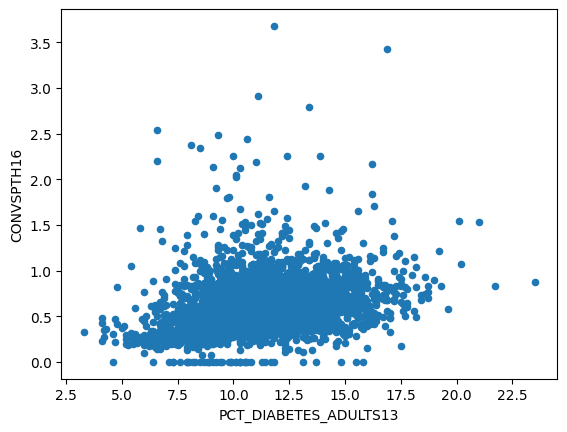

In [ ]:
#Looking at correlation between access to conveinet stores (# per 1000) and obesity.
plot1 = initial_df.plot.scatter(x="PCT_DIABETES_ADULTS13", y="CONVSPTH16")

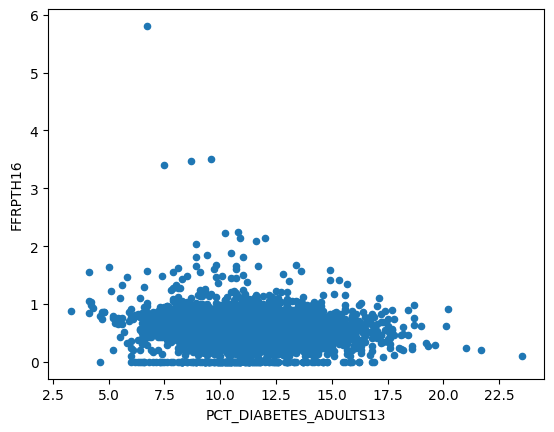

In [ ]:
plot1 = initial_df.plot.scatter(x="PCT_DIABETES_ADULTS13", y="FFRPTH16")

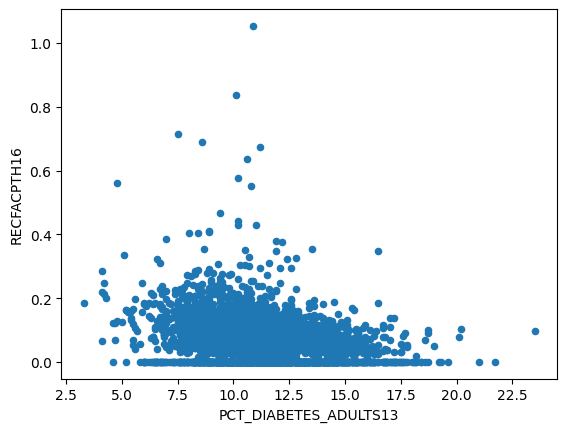

In [ ]:
plot1 = initial_df.plot.scatter(x="PCT_DIABETES_ADULTS13", y="RECFACPTH16")

Because the access to certain food vendors (groccery, convienence, fast food) are listed per 1000 people, we can make visualizations using only counties that have over or under 1 per a 1000 people to see the differences. Below is a histogram to show diabetes rates from counties with more than 1 convienence stores per 1000 people.

<Axes: ylabel='Frequency'>

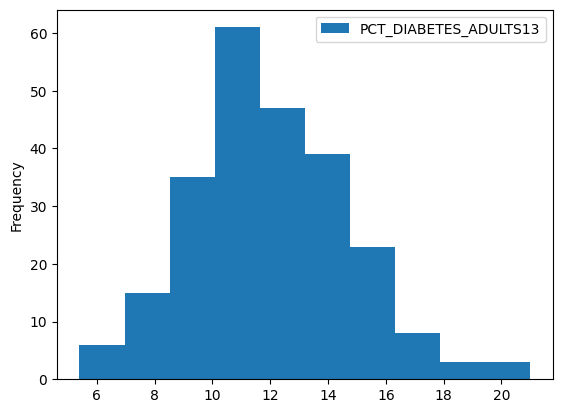

In [ ]:
initial_df[initial_df.CONVSPTH16 >= 1].PCT_DIABETES_ADULTS13.plot.hist(legend = True)

And now counties with less than 1 per 1000.

<Axes: ylabel='Frequency'>

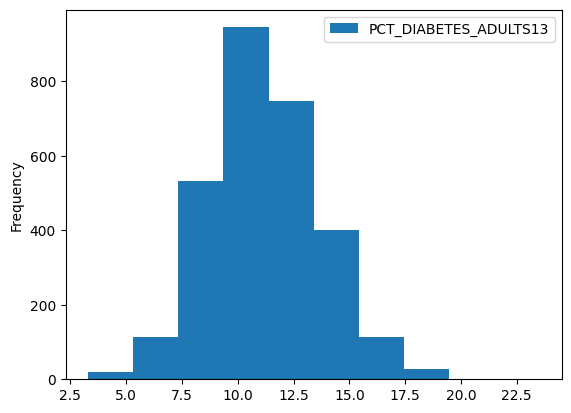

In [ ]:
initial_df[initial_df.CONVSPTH16 <= 1].PCT_DIABETES_ADULTS13.plot.hist(legend = True)

Now we will look at the same relationship and histograms but for groccery stores instead

<Axes: ylabel='Frequency'>

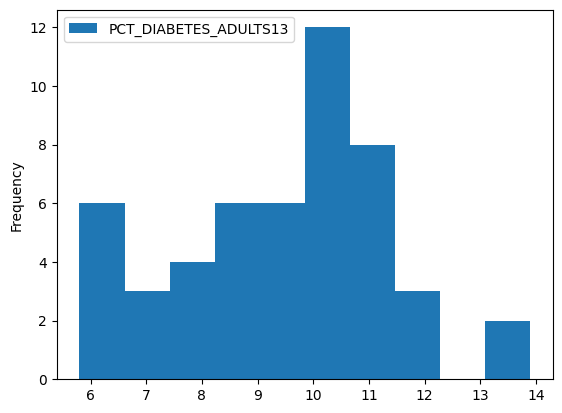

In [ ]:
initial_df[initial_df.GROCPTH16 >= 1].PCT_DIABETES_ADULTS13.plot.hist(legend = True)

<Axes: ylabel='Frequency'>

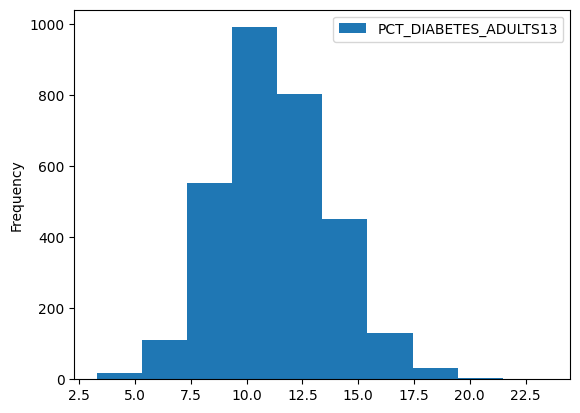

In [ ]:
initial_df[initial_df.GROCPTH16 <= 1].PCT_DIABETES_ADULTS13.plot.hist(legend = True)

We can see in both iterations of the histograms, when counties have more than 1 convienence or groccery store per 1000 people, the frequency of higher diabetes rates is greater.  

With our research questions clearly identified, we will now construct a dataframe that only contains relevant data. The columns have been renamed for clarity, and NaN values have been filled with the preceeding data point. Finally, we will add the state and county names for identification purposes.

In [ ]:
analysis_df_num = initial_df[['MEDHHINC15', 'PCT_DIABETES_ADULTS13', 'RECFACPTH16','CONVSPTH16', 'FFRPTH16', 'GROCPTH16']]
analysis_df_cat  = initial_df[['State', 'County']]
analysis_df_num = analysis_df_num.fillna(method = 'ffill')
analysis_df_num = analysis_df_num.rename(columns = {
    "MEDHHINC15" : "Median household income",
    "PCT_DIABETES_ADULTS13" : "percent of adults w/ diabetes",
    "RECFACPTH16" : "Recreation facilities per 1000 people",
    "CONVSPTH16" : "Convenience stores per 1000 people",
    "FFRPTH16" : "Fast food restaraunt per 1000 people",
    "GROCPTH16" : "Grocery stores per 1000 people"
})
analysis_df_final = pd.merge(analysis_df_cat, analysis_df_num, left_index=True, right_index= True, how='outer')
analysis_df_final

,State,County,Median household income,percent of adults w/ diabetes,Recreation facilities per 1000 people,Convenience stores per 1000 people,Fast food restaraunt per 1000 people,Grocery stores per 1000 people
0,Alabama,Autauga,56580.0,13.0,0.108542,0.560802,0.795977,0.054271
1,Alabama,Baldwin,52387.0,10.4,0.101200,0.568650,0.751775,0.139753
2,Alabama,Barbour,31433.0,18.4,0.000000,0.737177,0.892372,0.155195
3,Alabama,Bibb,40767.0,14.8,0.044183,0.662749,0.309283,0.220916
4,Alabama,Blount,50487.0,14.1,0.069490,0.469059,0.399569,0.086863
...,...,...,...,...,...,...,...,...
3138,Wyoming,Sweetwater,71867.0,8.1,0.135609,0.497231,0.700644,0.090406
3139,Wyoming,Teton,83290.0,4.8,0.560828,0.819672,0.862813,0.474547
3140,Wyoming,Uinta,62968.0,9.0,0.096567,0.627686,0.820820,0.096567
3141,Wyoming,Washakie,56088.0,12.0,0.122130,0.366390,0.732780,0.244260


Using Seaborn, we can create a readable correlation heatmap to further guide our research. We can pick out variables that may have an impact on the diabetes rate of a county.

<Axes: >

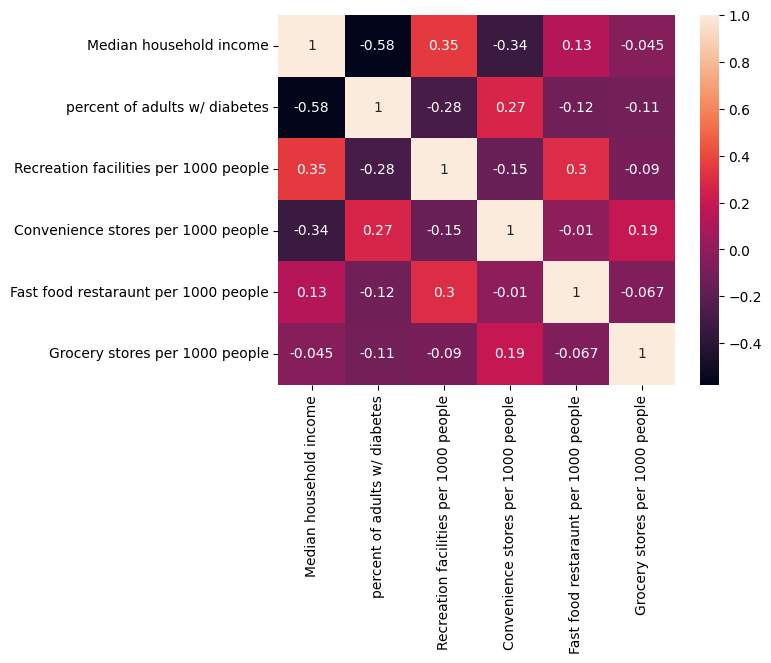

In [ ]:
sns.heatmap(analysis_df_num.corr(), annot=True)

The standout correlation here is the percentage of adults with diabetes and median household income in a county. They have a moderately strong negative correlation, with r = -0.58. Another notable relationship is between median household income and the number of recreation centers per 1,000 people. They have an r-value of 0.35.

Here is where we standardize the data, as we are working with values across different scales and metrics. Again, we rename the columns for clarity.

In [ ]:
analysis_df_std = (
    (analysis_df_num - analysis_df_num.mean()) /
    analysis_df_num.std()
)
analysis_df_std = analysis_df_std.rename(columns = {
    "Median household income" : "Standard deviation of median household income",
    "percent of adults w/ diabetes" : "Standard deviation of percent of adults w/ diabetes",
    "Recreation facilities per 1000 people" : "Standard deviation of recreation facilities per 1000 people",
    "Convenience stores per 1000 people" : "Standard deviation of convenience stores per 1000 people",
    "Fast food restaraunt per 1000 people" : "Standard deviation of fast food restaraunt per 1000 people",
    "Grocery stores per 1000 people" : "Standard deviation of grocery stores per 1000 people"
})

###Linear Regression

Below are the linear regressions and r^2 values. r^2 is a measurmeant of how well the regression line fits the data. Additionally, the Pearson coefficient and p-values are shown. The Pearson coefficient is simply a measure of correlation between two variables, and p-value is a measure of the likelihood that the relationship we see in the data is a product of random chance.

R-squared: 0.3314482930846765
Pearson correlation coefficient: -0.5757154619121119
P-value: 0.0000000000


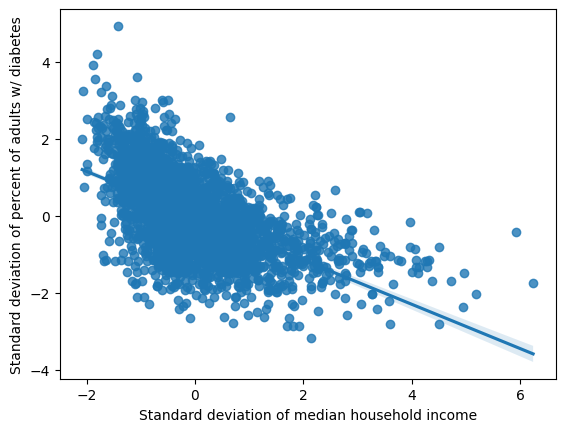

In [ ]:
y = analysis_df_std['Standard deviation of percent of adults w/ diabetes']
x = analysis_df_std[['Standard deviation of median household income']]
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r_squared = r2_score(y, y_pred)

sns.regplot(x='Standard deviation of median household income', y='Standard deviation of percent of adults w/ diabetes', data=analysis_df_std)
print("R-squared:", r_squared)

x = analysis_df_std['Standard deviation of median household income']
correlation_coef, p_value = pearsonr(x, y)
formatted_p_value = "{:.10f}".format(p_value)
print("Pearson correlation coefficient:", correlation_coef)
print("P-value:", formatted_p_value)

R-squared: 0.07681588259748395
Pearson correlation coefficient: -0.2771567834231811
P-value: 0.0000000000


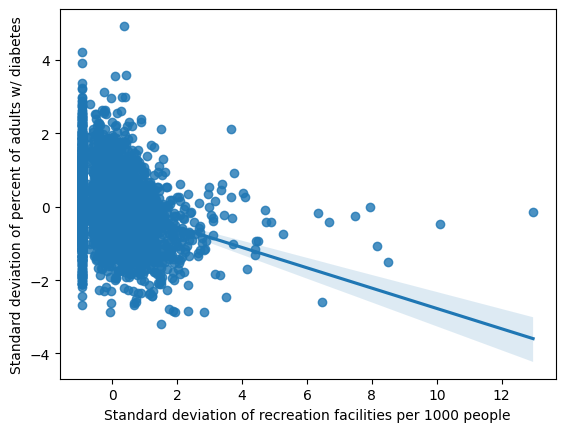

In [ ]:
y = analysis_df_std['Standard deviation of percent of adults w/ diabetes']
x = analysis_df_std[['Standard deviation of recreation facilities per 1000 people']]
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r_squared = r2_score(y, y_pred)

sns.regplot(x='Standard deviation of recreation facilities per 1000 people', y='Standard deviation of percent of adults w/ diabetes', data=analysis_df_std)
print("R-squared:", r_squared)

x = analysis_df_std['Standard deviation of recreation facilities per 1000 people']
correlation_coef, p_value = pearsonr(x, y)
formatted_p_value = "{:.10f}".format(p_value)
print("Pearson correlation coefficient:", correlation_coef)
print("P-value:", formatted_p_value)

R-squared: 0.07387055146863863
Pearson correlation coefficient: 0.2717913748974361
P-value: 0.0000000000


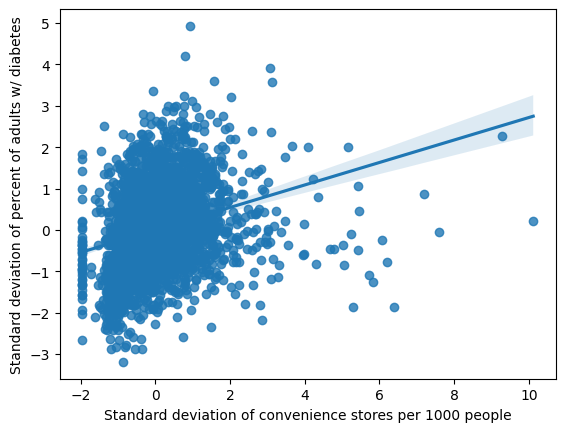

In [ ]:
y = analysis_df_std['Standard deviation of percent of adults w/ diabetes']
x = analysis_df_std[['Standard deviation of convenience stores per 1000 people']]
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r_squared = r2_score(y, y_pred)

sns.regplot(x='Standard deviation of convenience stores per 1000 people', y='Standard deviation of percent of adults w/ diabetes', data=analysis_df_std)
print("R-squared:", r_squared)

x = analysis_df_std['Standard deviation of convenience stores per 1000 people']
correlation_coef, p_value = pearsonr(x, y)
formatted_p_value = "{:.10f}".format(p_value)
print("Pearson correlation coefficient:", correlation_coef)
print("P-value:", formatted_p_value)

R-squared: 0.015261824890893005
Pearson correlation coefficient: -0.12353875865854087
P-value: 0.0000000000
Pearson correlation coefficient: -0.12353875865854087
P-value: 0.0000000000


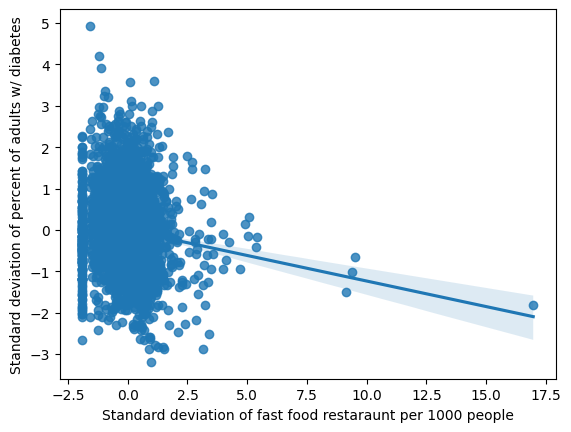

In [ ]:
y = analysis_df_std['Standard deviation of percent of adults w/ diabetes']
x = analysis_df_std[['Standard deviation of fast food restaraunt per 1000 people']]
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r_squared = r2_score(y, y_pred)

sns.regplot(x='Standard deviation of fast food restaraunt per 1000 people', y='Standard deviation of percent of adults w/ diabetes', data=analysis_df_std)
print("R-squared:", r_squared)

x = analysis_df_std['Standard deviation of fast food restaraunt per 1000 people']
correlation_coef, p_value = pearsonr(x, y)
formatted_p_value = "{:.10f}".format(p_value)
print("Pearson correlation coefficient:", correlation_coef)
print("P-value:", formatted_p_value)

x = analysis_df_std['Standard deviation of fast food restaraunt per 1000 people']
correlation_coef, p_value = pearsonr(x, y)
formatted_p_value = "{:.10f}".format(p_value)
print("Pearson correlation coefficient:", correlation_coef)
print("P-value:", formatted_p_value)

R-squared: 0.012806646915920039
Pearson correlation coefficient: -0.11316645667299145
P-value: 0.0000000002


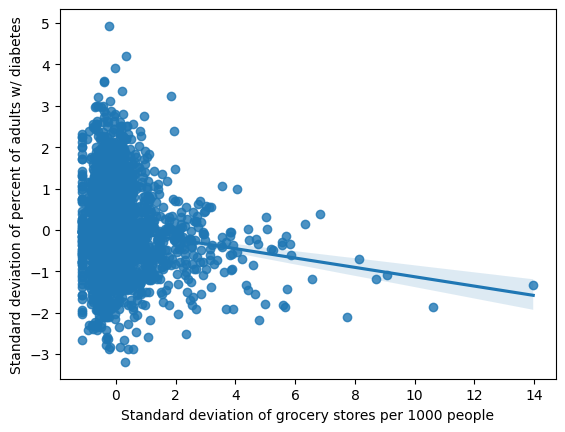

In [ ]:
y = analysis_df_std['Standard deviation of percent of adults w/ diabetes']
x = analysis_df_std[['Standard deviation of grocery stores per 1000 people']]
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r_squared = r2_score(y, y_pred)

sns.regplot(x='Standard deviation of grocery stores per 1000 people', y='Standard deviation of percent of adults w/ diabetes', data=analysis_df_std)
print("R-squared:", r_squared)

x = analysis_df_std['Standard deviation of grocery stores per 1000 people']
correlation_coef, p_value = pearsonr(x, y)
formatted_p_value = "{:.10f}".format(p_value)
print("Pearson correlation coefficient:", correlation_coef)
print("P-value:", formatted_p_value)

As seen in the graphs, the best fitting line is the regression of median household income and diabetes percentage with an r^2 score of .33. This relationship is the strongest of our examined variables. This is backed up by the Pearson coefficient and p-value. Given the relatively strong negative correlation and near-zero p-value, it can be reasonably inferred that there is indeed a strong relationship between diabetes and household income. However, there are many other factors not considered by this tutorial or by the dataset itself which might be causing the correlation. Therefore, it cannot be said with certainty that one factor causes the other.

###Creating KNN Models

Given the inferred relationship between income and diabetes, we next made a K nearest neighbors model to predict the percentage of a hypothetical county's population with diabetes. We are using the analysis_variables dataframe as our features. For this hypothethical county, we use the mean nation-wide values for rec centers, fast food restaurants, convenience stores, and fast food restaurants per thousand to better isolate the relationship between diabetes and income. To that end, we will be changing the income feature for the test feature set.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn import utils
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [ ]:
analysis_df = initial_df[['MEDHHINC15', 'PCT_DIABETES_ADULTS13', 'RECFACPTH16','CONVSPTH16', 'FFRPTH16', 'GROCPTH16']]

In [ ]:
analysis_df_std = (
    (analysis_df - analysis_df.mean()) /
    analysis_df.std()
)
analysis_df_std

,MEDHHINC15,PCT_DIABETES_ADULTS13,RECFACPTH16,CONVSPTH16,FFRPTH16,GROCPTH16
0,0.645143,0.709656,0.504324,-0.114008,0.686229,-0.875442
1,0.305683,-0.336395,0.407504,-0.088274,0.542577,-0.480671
2,-1.390724,2.882225,-0.927079,0.464332,0.999504,-0.409357
3,-0.635056,1.433846,-0.344411,0.220280,-0.895472,-0.105844
4,0.151862,1.152216,-0.010675,-0.414834,-0.602052,-0.724928
...,...,...,...,...,...,...
3138,1.882757,-1.261749,0.861261,-0.322458,0.376409,-0.708566
3139,2.807548,-2.589429,6.468857,0.734836,0.903439,1.065468
3140,1.162306,-0.899654,0.346401,0.105307,0.766967,-0.680112
3141,0.605311,0.307329,0.683512,-0.751492,0.480846,0.001960


When using K nearest neighbors regression, we will create two 'fantasy counties' to use as target values. Our first fantasy county has average values for all parameters. Our second fantasy county sees a major decrease in income only. This will again show us the relationship between diabetes rate and income through nearest neighbors predictions.

In [ ]:
#FANTASY COUNTY
new_county1 = pd.DataFrame()
new_county1["MEDHHINC15"] = [50000]
new_county1["RECFACPTH16"] = [0.05]
new_county1["CONVSPTH16"] = [0.6]
new_county1["FFRPTH16"] = [0.5]
new_county1["GROCPTH16"] = [0.3]


new_county2 = pd.DataFrame()
new_county2["MEDHHINC15"] = [25000]
new_county2["RECFACPTH16"] = [0.05]
new_county2["CONVSPTH16"] = [0.6]
new_county2["FFRPTH16"] = [0.5]
new_county2["GROCPTH16"] = [0.3]

Here we define our features for the model and scale the data.

In [ ]:
analysis_df = analysis_df.dropna()


x_train = analysis_df[["MEDHHINC15", "RECFACPTH16", "CONVSPTH16", "FFRPTH16", "GROCPTH16"]]
y_train = analysis_df["PCT_DIABETES_ADULTS13"]

scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)

KNN for our first, average income county.

In [ ]:
x_new_sc = scaler.transform(new_county1)


k_range = range(1, 51)
mae_points = []
rmse_points = []
for k in k_range:

  model = KNeighborsRegressor(n_neighbors=k)
  model.fit(x_train_sc, y_train)

  y_train_pred = model.predict(x_train_sc)

  #MAE
  mae = (y_train - y_train_pred).abs().mean()
  mae_points.append(mae)

  print(model.predict(x_new_sc))

[8.2]
[9.6]
[10.13333333]
[10.325]
[10.24]
[10.03333333]
[10.12857143]
[10.05]
[10.25555556]
[10.13]
[10.20909091]
[10.44166667]
[10.53076923]
[10.44285714]
[10.62]
[10.55625]
[10.61764706]
[10.52222222]
[10.62105263]
[10.68]
[10.66666667]
[10.56363636]
[10.6173913]
[10.71666667]
[10.64]
[10.63076923]
[10.61851852]
[10.64285714]
[10.69310345]
[10.65333333]
[10.65806452]
[10.68125]
[10.5969697]
[10.71470588]
[10.77142857]
[10.83333333]
[10.79189189]
[10.71052632]
[10.78717949]
[10.7475]
[10.82439024]
[10.8452381]
[10.81627907]
[10.87727273]
[10.86]
[10.84565217]
[10.91914894]
[10.89583333]
[10.8877551]
[10.882]


The same KNN model is used for a low income county.

In [ ]:
x_new_sc = scaler.transform(new_county2)


k_range = range(1, 51)
mae_points = []
rmse_points = []
for k in k_range:

  model = KNeighborsRegressor(n_neighbors=k)
  model.fit(x_train_sc, y_train)

  y_train_pred = model.predict(x_train_sc)

  #MAE
  mae = (y_train - y_train_pred).abs().mean()
  mae_points.append(mae)

  print(model.predict(x_new_sc))

[13.1]
[14.65]
[15.23333333]
[14.2]
[14.64]
[14.56666667]
[14.98571429]
[15.2625]
[15.31111111]
[15.28]
[15.10909091]
[14.875]
[14.82307692]
[14.96428571]
[15.15333333]
[15.35625]
[15.28235294]
[15.21666667]
[15.30526316]
[15.19]
[15.16190476]
[14.97727273]
[14.85652174]
[14.975]
[14.832]
[15.01538462]
[14.97407407]
[14.96071429]
[15.04827586]
[15.03333333]
[14.87419355]
[14.79375]
[14.76969697]
[14.80588235]
[14.82857143]
[14.78333333]
[14.76486486]
[14.73421053]
[14.76666667]
[14.7175]
[14.7097561]
[14.71190476]
[14.66744186]
[14.62727273]
[14.58444444]
[14.57173913]
[14.55106383]
[14.5625]
[14.59387755]
[14.636]


Between these two hypothetical counties, with all else equal, the one with higher income is predicted to have a lower diabetes rate. The difference is expected to be about 5%.

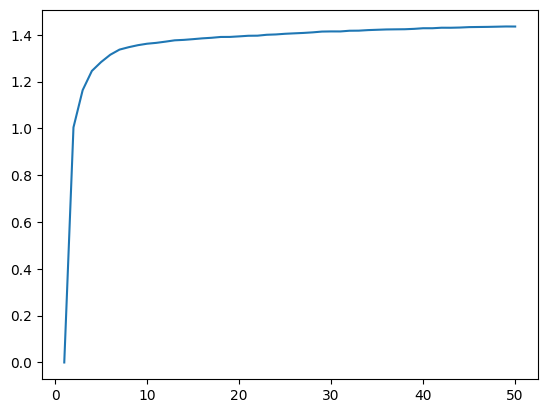

In [ ]:
plt.plot(k_range, mae_points)

###Cross-Validation

We will now perform cross validation to assess how accurate our model is.

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

In [ ]:
train = analysis_df.sample(frac=.5)
val = analysis_df.drop(train.index)

train

,MEDHHINC15,PCT_DIABETES_ADULTS13,RECFACPTH16,CONVSPTH16,FFRPTH16,GROCPTH16
2494,36316.0,15.1,0.091000,0.728001,0.546001,0.227500
1486,42480.0,11.7,0.038647,0.579710,0.502415,0.115942
3113,45043.0,10.5,0.128123,0.576553,0.384369,0.320307
1704,46888.0,9.1,0.000000,1.603750,0.986923,0.370096
231,47535.0,9.6,0.000000,0.337382,0.337382,0.337382
...,...,...,...,...,...,...
1887,85688.0,8.2,0.202329,0.264663,0.786835,0.495604
1759,54416.0,7.8,0.000000,0.908265,0.454133,0.151378
745,41407.0,10.5,0.094276,0.370749,0.881324,0.175841
330,62385.0,8.6,0.128382,0.275885,0.524454,0.166623


In [ ]:
features = ["MEDHHINC15", "RECFACPTH16", "CONVSPTH16", "FFRPTH16", "GROCPTH16"]

X_train_dict = train[features].to_dict(orient="records")
X_val_dict = val[features].to_dict(orient="records")

y_train = train["PCT_DIABETES_ADULTS13"]
y_val = val["PCT_DIABETES_ADULTS13"]

In [ ]:
pipeline = Pipeline([("scaler", scaler),("model", model)])
vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
cross_val_score(pipeline, X_train, y_train, cv=20)

array([0.39184456, 0.24336754, 0.54441691, 0.23989297, 0.45971088,
       0.4639586 , 0.20896063, 0.48614421, 0.34423436, 0.34051366,
       0.34808885, 0.41222073, 0.40215973, 0.35181964, 0.35449815,
       0.41798758, 0.41701867, 0.47284542, 0.33673352, 0.43717976])

In [ ]:
def get_val_error(X_train_dict, y_train, X_val_dict, y_val):

    # convert categorical variables to dummy variables
    vec = DictVectorizer(sparse=False)
    vec.fit(X_train_dict)
    X_train = vec.transform(X_train_dict)
    X_val = vec.transform(X_val_dict)

    # standardize the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_val_sc = scaler.transform(X_val)

    # Fit a 10-nearest neighbors model.
    model = KNeighborsRegressor(n_neighbors=10)
    model.fit(X_train_sc, y_train)

    # Make predictions on the validation set.
    y_val_pred = model.predict(X_val_sc)
    rmse = np.sqrt(((y_val - y_val_pred) ** 2).mean())

    return rmse

In [ ]:
get_val_error(X_train_dict, y_train, X_val_dict, y_val)

1.913980166167308

In [ ]:
get_val_error(X_val_dict, y_val, X_train_dict, y_train)

1.9324710757469892

Our final validation error is about 1.91. Our model has room for improvement, however, given the previously established relationship between diabetes and income, it is a great start.

###Conclusion


Based on our research, we feel we have enough evidence to make a reasonable inference that there is a relationship between household income and diabetes. Of course, we would need a deeper study before objectively stating if one factor causes the other. There could be other factors at play contributing to this relationship, but we are confident that income likely has an impact on the diabetes rate of a county.

Though the external variables did have a slight correlation with the diabetes, and possibly also have a similar relationship with median household income, more testing would have to be done to determine the reality of this claim.